In [1]:
import os
from skimage.data import imread
from skimage.morphology import label
from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
#import gc; gc.enable() # memory is tight

In [2]:
ship_dir = 'input'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [3]:
masks = pd.read_csv(os.path.join('input/',
                                 'train_ship_segmentations_v2.csv'))

In [4]:
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
def pixels_areNaN(x):
    if x == x:
        return False
    else:
        return True

In [6]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

In [7]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

In [9]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


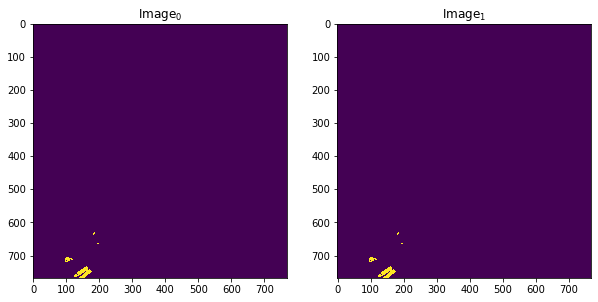

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
29648,275cc7c75.jpg,0,0.0,[0.0],98.172852
175144,e8e879083.jpg,0,0.0,[0.0],88.369141
13125,115e7613c.jpg,0,0.0,[0.0],178.000000
50319,42fb7445a.jpg,3,1.0,[1.0],112.491211
167175,de5a93510.jpg,0,0.0,[0.0],121.841797


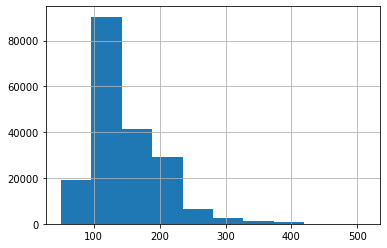

In [11]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [12]:
data = pd.merge(masks, unique_img_ids)

In [13]:
data.has_ship.value_counts()

0.0    149293
1.0     80789
Name: has_ship, dtype: int64

In [15]:
data['label'] = data['has_ship'].map(lambda x: "boat" if x>0 else "nature")

In [16]:
data.label.value_counts()

nature    149293
boat       80789
Name: label, dtype: int64

In [17]:
print(data.shape[0], 'masks')

230082 masks


In [18]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161048 training masks
69034 validation masks


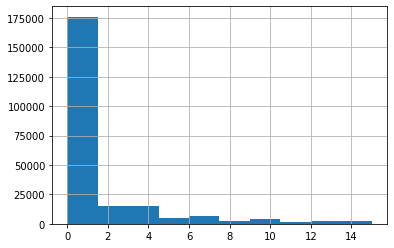

In [19]:
data['ships'].hist()

In [20]:
data.ships.value_counts()

0     149293
1      26737
2      15126
3       8724
4       6432
5       4585
6       3912
7       2835
8       2512
9       2169
10      1680
11      1584
12      1464
14      1064
15       990
13       975
Name: ships, dtype: int64

In [21]:
data.drop('file_size_kb', axis=1, inplace=True)

In [22]:
data.drop('has_ship_vec', axis=1, inplace=True)

In [23]:
data.head()

,ImageId,EncodedPixels,ships,has_ship,label
0,00003e153.jpg,NaN,0,0.0,nature
1,0001124c7.jpg,NaN,0,0.0,nature
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,1.0,boat
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5,1.0,boat
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5,1.0,boat


In [24]:
data[data["ships"]<2].to_csv("output/data_zero_to_one_ships.csv")

In [25]:
data[data["ships"]<3].to_csv("output/data_zero_to_two_ships.csv")

In [26]:
data[data["ships"]<4].to_csv("output/data_zero_to_three_ships.csv")

In [27]:
data[data["ships"]<5].to_csv("output/data_zero_to_four_ships.csv")